In [1]:
# -*- coding: utf-8 -*-
"""
用于数值型和字符型变量的分箱类。
支持手动分箱，等频分箱，单调分箱，IV、WOE计算及转换。
@author: 
@date: new_version on 2018/11/3
"""

'\n用于数值型和字符型变量的分箱类。\n支持手动分箱，等频分箱，单调分箱，IV、WOE计算及转换。\n@author: \n@date: new_version on 2018/11/3\n'

In [4]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import pandas as pd
import numpy as np
from pylab import mpl
mpl.rcParams['font.sans-serif'] = ['SimHei'] #指定默认字体    
mpl.rcParams['axes.unicode_minus'] = False #解决保存图像是负号'-'显示为方块的问题
try:
    import cPickle as pickle
except ImportError:
    import pickle
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [5]:
pd.set_option('display.max_columns', 100000)  
pd.set_option('display.max_rows', 10000) 

In [6]:
class XXDNumberBin():
    '''
    分箱类
    '''
    def __init__(self):
        self.__bin_stats = None
        
    def get_bin_stats(self):
        if self.__bin_stats is not None:
            return self.__bin_stats.reset_index(drop=True)
    
    def get_cutoff(self):
        if self.__bin_stats is not None:
            return self.__bin_stats.Max.dropna().tolist()
    
    def trans_bin_to_woe(self,B):
        '''
        
        B: Series
        '''
        if self.__bin_stats is None:
            raise ValueError('ERROR: 尚未调用分箱函数，无法转换!')
        woe =  self.__bin_stats['WoE'].sort_index()
        return B.map(lambda x:woe[x])
    
    def plot_woe(self,title=None):
        if self.__bin_stats is None:
            raise ValueError('ERROR: 尚未调用分箱函数，无法转换!')
        woe =  self.__bin_stats[['WoE','Range']].sort_index()
        plt.clf()
        if title is None:
            title = self.__varname
        plt.title('{}(WOE)'.format(title))
        plt.bar(range(len(woe)), woe.WoE,tick_label=woe.Range)
        plt.show()
        print('Cutoff:{}'.format(self.get_cutoff()))
        
    def get_iv(self):
        if self.__bin_stats is None:
            raise ValueError('ERROR: 尚未调用分箱函数，无法转换!')
        return self.__bin_stats['TotalIV'].iloc[0]
    
    def get_varname(self):
        return self.__varname;
    
    def trans_to_bin(self,X):
        '''
        如果训练集有缺失：
        1）缺失值分到缺失组，
        2）小于最小值的分到第一组
        3) 超过最大值的分最后一组。
        如果训练集没有缺失：
        1）缺失值\小于最小值分到第一组；
        2）超过最大值的分最后一组
        
        X: series
        '''
        if self.__bin_stats is None:
            raise ValueError('ERROR: 尚未调用分箱函数，无法转换!')
        if not is_numeric_dtype(X):
            X = X.astype(float)
        cuts = self.__bin_stats['Max'].sort_values(na_position ='first')
        mx = cuts.max()
        return X.map(lambda x:(cuts>=x).idxmax() if x<=mx else cuts.index[-1],na_action='ignore').fillna(cuts.index[0])
    
    def trans_to_woe(self,X):
        '''
        如果训练集有缺失：
        1）缺失值分到缺失组，
        2）小于最小值的分到第一组
        3) 超过最大值的分最后一组。
        如果训练集没有缺失：
        1）缺失值\小于最小值分到第一组；
        2）超过最大值的分最后一组
        X : series
        '''
        if self.__bin_stats is None:
            raise ValueError('ERROR: 尚未调用分箱函数，无法转换!')
        if not is_numeric_dtype(X):
            X = X.astype(float)
        cuts = self.__bin_stats['Max'].sort_values(na_position ='first')
        mx = cuts.max()
        woe =  self.__bin_stats['WoE'].sort_index()
        return X.map(lambda x:woe[(cuts>=x).idxmax()] if x<=mx else woe.iloc[-1] ,na_action='ignore').fillna(woe.iloc[0])
    
    def __cc(self,dfx):
            mx=dfx.XX.max()
            mn=dfx.XX.min()
            cnt=len(dfx)
            bad=dfx.YY.sum()
            good=cnt-bad            
            return pd.Series({'Var':self.__varname,'Range':'<={:.3f}'.format(mx) if pd.notna(mx) else 'Miss',
                              'Min':mn, 'Max':mx,'CntRec':cnt,'CntGood':good,'CntBad':bad})
        
    def calc_stats(self,data):
        '''
        计算woe，iv等。
        data: df[['bin','XX',YY']]
        '''
        res = data.groupby(data['bin']).apply(self.__cc)      
        cntg= (data.YY==0).sum()
        cntb= (data.YY==1).sum()
        res['Pct']=res.CntRec/len(data)
        res['PctBad']=res.CntBad/cntb
        res['PctGood']=res.CntGood/cntg
        res['BadRate']=res.CntBad/res.CntRec
        res['CumGood']=res.CntGood.cumsum()
        res['CumBad']=res.CntBad.cumsum()
        res['Odds']=res.BadRate/(1-res.BadRate)
        res['LnOdds']=np.log(res.Odds)
        woe = np.log(res.PctBad/res.PctGood)
        woe[res.PctBad==0] = 20
        woe[res.PctGood==0] = -20
        res['WoE'] = woe
        res['IV'] = (res.PctBad-res.PctGood)*res.WoE
        res['TotalIV'] = res.IV[(res.PctBad>0)&(res.PctGood>0)].sum()
        #res=res.append(pd.Series({'Var':x,'Min':XX.min(),'Max':XX.max(),'LnOdds':np.log(),'IV':res.IV.sum()},name='ALL'))
        return res
    def manual_bin(self,df,x,y,cutoff=[]):
        '''
        手动分箱
        df: 数据
        x: 变量名
        y: 目标变量
        '''
        self.__varname = x
        XX,YY = df[x],df[y]
        assert YY.isin([0,1]).all(),'ERROR: {} 目标变量非0/1!'.format(y)
        if not is_numeric_dtype(XX):
            XX = XX.astype(float) 
        data = pd.DataFrame({'XX':XX,'YY':YY})
        cnt = XX.count()
        assert cnt>0,'ERROR: "{}" 变量值全为 NULL  !'.format(x)
        edges = pd.Series(cutoff+[np.inf]).sort_values()
        mx = edges.max()
        data['bin'] = XX.map(lambda x:(edges>=x).idxmax() if x<=mx else edges.index[-1],na_action='ignore').fillna(-1)
        self.__bin_stats= self.calc_stats(data)
        
    def pct_bin(self,df,x,y,max_bin=10,min_pct=0.06):        
        '''
        等频分箱。
        df: 数据
        x: 变量名
        y: 目标变量
        '''
        self.__varname = x
        XX,YY = df[x],df[y]
        assert YY.isin([0,1]).all(),'ERROR: {}  目标变量非0/1!'.format(y)
        if not is_numeric_dtype(XX):
            XX = XX.astype(float) 
        data = pd.DataFrame({'XX':XX,'YY':YY})
        cnt = XX.count()
        assert cnt>0,'ERROR: "{}" 变量值全为 NULL  !'.format(x)
        min_sample = int(len(XX)*min_pct)
        if cnt<= min_sample:
            print('WARN: "{}" 非空值少于 {} !'.format(x,min_pct))
        nuniq = XX.nunique()
        if nuniq<= 50:
            print('WARN: "{}" 数值型变量只有 {} 个取值!'.format(x,nuniq))
        cut_ok = False
        ZZ = XX.rank(pct=1)
        while not cut_ok:
            edges = pd.Series(np.linspace(0,1,max_bin+1))
            bins =ZZ.map(lambda r:(edges>=r).idxmax(),na_action='ignore').fillna(-1)
            cut_ok = True
            if bins.value_counts().min() < min_sample and cnt>min_sample and max_bin>1:
                max_bin=max_bin-1
                cut_ok=False
        data['bin']=bins
        self.__bin_stats= self.calc_stats(data)
        
    def monotone_bin(self,df,x,y,max_bin=10):
        '''
        单调分箱。
        df: 数据
        x: 变量名
        y: 目标变量
        '''
        self.__varname = x
        XX,YY = df[x],df[y]
        assert YY.isin([0,1]).all(),'ERROR: {} 目标变量非0/1!'.format(y)
        if not is_numeric_dtype(XX):
            XX = XX.astype(float) 
        data = pd.DataFrame({'XX':XX,'YY':YY})
        cnt = XX.count()
        assert cnt>0,'ERROR: "{}" 变量值全为 NULL  !'.format(x)
        cut_ok = False
        ZZ = XX.rank(pct=1)
        while not cut_ok:
            edges = pd.Series(np.linspace(0,1,max_bin+1))
            data['bin']=ZZ.map(lambda r:(edges>=r).idxmax(),na_action='ignore').fillna(-1)
            res=self.calc_stats(data).sort_index()
            woe = res[~res.Max.isna()].WoE
            cut_ok = woe.is_monotonic_decreasing or woe.is_monotonic_increasing
            max_bin = max_bin-1
        self.__bin_stats= res
    

class XXDCharBin():
    def __init__(self):
        self.__bin_stats=None
    
    def get_bin_stats(self):
        if self.__bin_stats is not None:
            return self.__bin_stats.copy()
        
    def trans_bin_to_woe(self,B):
        if self.__bin_stats is None:
            raise ValueError('ERROR: 尚未调用分箱函数，无法转换!')
        data = B.to_frame()
        woe =  self.__bin_stats['WoE'].sort_index()
        return B.map(lambda x:woe[x],na_action='ignore').fillna(woe.iloc[0])
    
    def plot_woe(self,title=None):
        if self.__bin_stats is None:
            raise ValueError('ERROR: 尚未调用分箱函数，无法转换!')
        woe =  self.__bin_stats[['WoE','Range']].sort_values(by='WoE')
        plt.clf()
        if title is None:
            title = self.__varname
        plt.title('{}(WOE)'.format(title))
        plt.bar(range(len(woe)), woe.WoE)
        plt.show()
        print(woe.Range.reset_index(drop=True))
        
    def get_iv(self):
        if self.__bin_stats is None:
            raise ValueError('ERROR: 尚未调用分箱函数，无法转换!')
        return self.__bin_stats['TotalIV'].iloc[0]
    
    def get_varname(self):
        return self.__varname;
    
    def trans_to_bin(self,X):
        '''
        新值分到缺失
        X: series
        '''
        if self.__bin_stats is None:
            raise ValueError('ERROR: 尚未调用分箱函数，无法转换!')
        if not is_string_dtype(X):
            X = X.astype(str)
        data = X.to_frame()
        data['bin'] = -1
        for bin,values in enumerate(self.__bins):
            data.loc[X.isin(values),'bin']=bin
        return data['bin']
    
    def trans_to_woe(self,X):
        '''
        新值分到缺失
        X: series
        '''
        if self.__bin_stats is None:
            raise ValueError('ERROR: 尚未调用分箱函数，无法转换!')
        if not is_string_dtype(X):
            X = X.astype(str)
        data = X.to_frame()
        woe =  self.__bin_stats['WoE'].sort_index()
        data['woe'] = woe.iloc[0]
        for bin,values in enumerate(self.__bins):
            data.loc[X.isin(values),'woe']=woe[bin]
        return data['woe']
    
    def __cc(self,dfx):
            cnt=len(dfx)
            bad=dfx.YY.sum()
            good=cnt-bad            
            return pd.Series({'Var':self.__varname,'Range':dfx.XX.unique(),'CntRec':cnt,'CntGood':good,'CntBad':bad})
        
    def calc_stats(self,data):
        '''
        计算woe，iv等。
        '''
        res = data.groupby(data['bin']).apply(self.__cc)      
        cntg= (data.YY==0).sum()
        cntb= (data.YY==1).sum()
        res['Pct']=res.CntRec/len(data)
        res['PctBad']=res.CntBad/cntb
        res['PctGood']=res.CntGood/cntg
        res['BadRate']=res.CntBad/res.CntRec
        res['CumGood']=res.CntGood.cumsum()
        res['CumBad']=res.CntBad.cumsum()
        res['Odds']=res.BadRate/(1-res.BadRate)
        res['LnOdds']=np.log(res.Odds)
        woe = np.log(res.PctBad/res.PctGood)
        woe[res.PctBad==0] = 20
        woe[res.PctGood==0] = -20
        res['WoE'] = woe
        res['IV'] = (res.PctBad-res.PctGood)*res.WoE
        res['TotalIV'] = res.IV[(res.PctBad>0)&(res.PctGood>0)].sum()
        return res
    def manual_bin(self,df,x,y,bins=[]):
        '''
        手动分箱
        df: 数据
        x: 变量名
        y: 目标变量
        bins: [['a'],['b'],['c','d'],['e']]
        '''
        self.__varname = x
        data = pd.DataFrame({'XX':df[x],'YY':df[y]})
        assert data.YY.isin([0,1]).all(),'ERROR: {} 目标变量非0/1!'.format(y)
        if not is_string_dtype(data.XX):
            data['XX'] = data.XX.astype(str) 
        cnt = data.XX.count()
        assert cnt>0,'ERROR: "{}" 变量值全为 NULL  !'.format(x)
        data['bin'] = -1
        for i,values in enumerate(bins):
            data.loc[data.XX.isin(values),'bin']=i
        data.loc[data.XX.isnull(),'bin'] = -2
        self.__bins=bins.copy()
        res = self.calc_stats(data)
        self.__bin_stats= res
        
    def pct_bin(self,df,x,y,sp_bins = [],max_bin=10): 
        '''
        字符型自动分箱，
        sp_bins: 特殊值分箱. [['a'],['b'],['c','d'],['e']]
        df: 数据
        x: 变量名
        y: 目标变量
        '''
        spvars = []
        for binb in sp_bins:
                spvars = spvars + binb
        assert len(set(spvars))==len(spvars),'ERROR: "{}" : sp_bins are overlapping!'.format(x)
        data = pd.DataFrame({'XX':df[x],'YY':df[y]})
        assert data.YY.isin([0,1]).all(),'ERROR: {} 目标变量非0/1!'.format(y)
        data = data.dropna()
        cnt = data.shape[0]
        assert cnt>0,'ERROR: "{}" 变量值全为 NULL  !'.format(x)
        if not is_string_dtype(data.XX):
            data['XX'] = data.XX.astype(str) 
        nuniq = data.XX.nunique()
        if nuniq> 50:
            print('WARN: "{}" 字符型变量取值数超过 {} 个!'.format(x,nuniq))
    
        db = data[~data.XX.isin(spvars)]
        dbr=db.groupby('XX').YY.mean().reset_index()
        dbr['rr'] = dbr.YY.rank(pct=1)
        edges = pd.Series(np.linspace(0,1,max_bin+1))
        dbr['bin'] =dbr.rr.map(lambda r:(edges>=r).idxmax())
        xx = dbr.groupby('bin').apply(lambda yy:yy.XX.tolist())
        sp_bins = sp_bins +xx.tolist()
        self.manual_bin(df,x,y,sp_bins.copy())

In [7]:
class XXDBinUtils():
    '''
    批量分箱类
    '''
    def __init__(self,df,y):
        self.__df = df
        self.__y=y
        self.__bins={}
    def auto_bin(self,ignore=[],params={}):
        for col in self.__df.columns:
            if col == self.__y or col in ignore:
                continue
            max_bin = params['max_bin'] if 'max_bin' in params else 10
            min_pct = params['min_pct'] if 'min_pct' in params else 0.06
            print('now binning {}...'.format(col))
            if is_numeric_dtype(self.__df[col]):
                nb = XXDNumberBin()
                nb.pct_bin(self.__df,col,self.__y,max_bin=max_bin,min_pct=min_pct)
                self.__bins[col] = nb
                
            else: 
                cb = XXDCharBin()
                cb.pct_bin(self.__df,col,self.__y,max_bin=max_bin)
                self.__bins[col] = cb
        print('done.')
        
    def manual_bin(self,col,bins_or_cutoff):
        assert col != self.__y,'ERROR: 不能对目标变量分箱！'
        if col in self.__bins:
            self.__bins[col].manual_bin(self.__df,col,self.__y,bins_or_cutoff)
        elif is_numeric_dtype(self.__df[col]):
                nb = XXDNumberBin()
                nb.manual_bin(self.__df,col,self.__y,bins_or_cutoff)
                self.__bins[col] = nb
                
        else: 
                cb = XXDCharBin()
                cb.manual_bin(self.__df,col,self.__y,bins_or_cutoff)
                self.__bins[col] = cb
        print('done.')
    def get_bin(self,col):
        return self.__bins.get(col)
    
    def trans_to_woe(self,df,inplace=False):
        res = pd.DataFrame()
        if inplace:
            res = df
        for col in df.columns:
            if col in self.__bins:
                res['woe_{}'.format(col)] = self.__bins[col].trans_to_woe(df[col])
        return res
    
    def get_all_bin_stats(self):
        res = pd.DataFrame()
        for col in self.__bins:
            res = res.append(self.__bins[col].get_bin_stats())
        return res
    
    def dump(self,filename):
        f = open(filename, 'wb')
        pickle.dump(self.__bins,f)
        f.close()
        print('done.')
        
    def load(self,filename):
        f = open(filename, 'rb')
        d = pickle.load(f)
        f.close()
        self.__bins = d
        print('done.')
        
    def iv_ks_auc(self):
        result = []
        y = self.__df[self.__y].values
        for col in self.__bins:
                woe = self.__bins[col].trans_to_woe(self.__df[col])
                iv = self.__bins[col].get_iv()
                ks = stats.ks_2samp(woe[y==0], woe[y==1]).statistic
                auc = metrics.roc_auc_score(y,woe)
                result.append((col,iv,ks,auc))
        return pd.DataFrame(result,columns=['var','iv','ks','auc'])
    
    def plot_woe(self,col,title=None):
        if col in self.__bins:
            self.__bins[col].plot_woe(title)
    def plot_all_woe(self,min_iv=0.0,max_iv=10.0):
        '''

        :param min_iv:
        :return:
        '''
        for col in self.__bins:
            binn = self.__bins[col]
            iv = binn.get_iv()
            if min_iv <= iv<= max_iv:
                print('"{}"  :  iv={}'.format(col,iv))
                self.__bins[col].plot_woe()


In [8]:
def sample_split(df,y, test_size=0.3):
    """
    split dataset into train and test without over sampling
    Train_Test_Split_nooversample

    df：数据集
    y：Y变量名称
    test_size：测试集占总样本的比例
    """
    train_df,test_df = train_test_split(df,random_state=123,test_size=test_size,stratify=y)
#     target = target_name
#     Y = df[target]
#     X_df = df.drop(target, axis=1)
#     x_train, x_test, y_train, y_test = train_test_split(
#         X_df, Y, test_size=test_size, stratify=Y, random_state=123
#     )
    return train_df,test_df

def sample_split_over(df, target_name, test_size=0.3, n=1): # 过抽样，暂时保密    
    """
    split dataset into train and test with over sampling
    Train_Test_Split_oversample

    df：数据集
    target_name：Y变量名称
    test_size：测试集占总样本的比例
    n:好客户比坏客户的倍数
    """
def sample_split_summary(y_train,y_test):
    '''
    该函数为训练集和测试集划分的统计结果

    Args:

    y_train(DataFrame):训练集y数据
    y_test(DataFrame):测试集的y数据

    Returns：
    New DataFrame:训练集和测试集的划分结果
    '''
    train = ['train',len(y_train),y_train.value_counts()[0]\
             ,y_train.value_counts()[1],1.0*y_train.value_counts()[1]/len(y_train),\
           1.0*len(y_train)/(len(y_train)+len(y_test))]
    test = ['test',len(y_test),y_test.value_counts()[0]\
             ,y_test.value_counts()[1],1.0*y_test.value_counts()[1]/len(y_test),\
            1.0*len(y_test)/(len(y_train)+len(y_test))]
    sum_ = ['sum',len(y_train)+len(y_test),
            y_train.value_counts()[0]+y_test.value_counts()[0],
            y_train.value_counts()[1]+y_test.value_counts()[1],
            1.0*(y_train.value_counts()[1]+y_test.value_counts()[1])/(len(y_train)+len(y_test)),
            1.0*len(y_train)/(len(y_train)+len(y_test))+1.0*len(y_test)/(len(y_train)+len(y_test))
            ]
    return pd.DataFrame([train,test,sum_],columns=['split','total','good','bad','rate','dist'])


In [9]:
demo_df = pd.read_csv('D:/shaojie/NutsCloud/My/binut_demo/data.csv')
demo_df.head()
demo_df.columns.tolist()
char_var = demo_df.select_dtypes('object')
char_var.columns.tolist()
demo_df.shape

(656, 39)

In [10]:
# 找出id的变量
drop_list = [col for col  in demo_df.columns if ('_id' in col) or ('id_' in col) ]+['domain','primary_city','state',
                                                                                   'bank_nm','email_dur']
drop_list

['cust_id',
 'loan_id',
 'domain',
 'primary_city',
 'state',
 'bank_nm',
 'email_dur']

# 拆分数据集

In [11]:
train_df,test_df=sample_split(demo_df,demo_df['flgGood'],test_size=0.3)
summary_y =sample_split_summary(train_df['flgGood'],test_df['flgGood'])
# summary_y.to_excel(result_path+'/y_summary.xlsx')
summary_y

,split,total,good,bad,rate,dist
0,train,459,248,211,0.459695,0.699695
1,test,197,106,91,0.461929,0.300305
2,sum,656,354,302,0.460366,1.000000


# 开始进行分箱,此处拿等频分箱做案例

## 调用分箱

In [12]:
y = 'flgGood'
binut = XXDBinUtils(train_df,y)
binut.auto_bin( ignore=drop_list,params={'max_bin':10,'min_sample':50})

now binning applicant_age...
now binning amt_req...
WARN: "amt_req" 数值型变量只有 11 个取值!
now binning rent_own...
WARN: "rent_own" 数值型变量只有 2 个取值!
now binning mthly_rent_amt...
now binning bank_acct_dd...
WARN: "bank_acct_dd" 数值型变量只有 2 个取值!
now binning loan_dur...
WARN: "loan_dur" 数值型变量只有 7 个取值!
now binning pmt_ach...
WARN: "pmt_ach" 数值型变量只有 2 个取值!
now binning nm_pmt...
WARN: "nm_pmt" 数值型变量只有 15 个取值!
now binning pmt_amt...
now binning amt_aprv...
WARN: "amt_aprv" 数值型变量只有 8 个取值!
now binning dur_aprv...
WARN: "dur_aprv" 数值型变量只有 7 个取值!
now binning pmt_amt_aprv...
now binning county...
WARN: "county" 字符型变量取值数超过 61 个!
now binning res_dur...
now binning bank_acct_dur...
now binning pmt_freq...
now binning home_phone_type...
now binning has_other_phone...
WARN: "has_other_phone" 数值型变量只有 2 个取值!


d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:285: RuntimeWarning: divide by zero encountered in log
d:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:286: RuntimeWarning: divide by zero encountered in log


now binning how_use_money...
now binning mthly_income_amt...
now binning raw_l2c_score...
now binning raw_FICO_telecom...
now binning raw_FICO_retail...
now binning raw_FICO_bank_card...
now binning raw_FICO_money...
now binning req_inc_ratio...
now binning rent_ratio...
now binning pmt_ratio...
now binning pmt_amt_apv_match...
WARN: "pmt_amt_apv_match" 数值型变量只有 2 个取值!
now binning amt_apv_match...
WARN: "amt_apv_match" 数值型变量只有 2 个取值!
now binning name...
done.


## 调用iv_ks_auc方法

In [13]:
binut.iv_ks_auc().head()

,var,iv,ks,auc
0,applicant_age,0.126784,0.142715,0.596832
1,amt_req,0.026615,0.057617,0.540514
2,rent_own,0.039365,0.093564,0.546782
3,mthly_rent_amt,0.020207,0.062146,0.538765
4,bank_acct_dd,0.016673,0.051158,0.525579


## 调用分箱统计量方法

In [14]:
binut.get_all_bin_stats().head()

d:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,BadRate,CntBad,CntGood,CntRec,CumBad,CumGood,IV,LnOdds,Max,Min,Odds,Pct,PctBad,PctGood,Range,TotalIV,Var,WoE
0,0.363636,16,28,44,16,28,0.014757,-0.559616,26.0,19.0,0.571429,0.095861,0.075829,0.112903,<=26.000,0.126784,applicant_age,-0.398045
1,0.418605,18,25,43,34,53,0.002587,-0.328504,30.0,27.0,0.720000,0.093682,0.085308,0.100806,<=30.000,0.126784,applicant_age,-0.166933
2,0.396226,21,32,53,55,85,0.007661,-0.421213,34.0,31.0,0.656250,0.115468,0.099526,0.129032,<=34.000,0.126784,applicant_age,-0.259643
3,0.421053,16,22,38,71,107,0.002021,-0.318454,38.0,35.0,0.727273,0.082789,0.075829,0.088710,<=38.000,0.126784,applicant_age,-0.156883
4,0.352941,18,33,51,89,140,0.021231,-0.606136,41.0,39.0,0.545455,0.111111,0.085308,0.133065,<=41.000,0.126784,applicant_age,-0.444565


## 调用woe画图

"applicant_age"  :  iv=0.12678428559583058


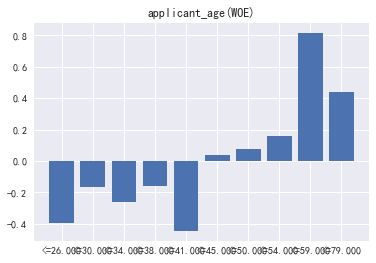

Cutoff:[26, 30, 34, 38, 41, 45, 50, 54, 59, 79]
"amt_req"  :  iv=0.026614832725776128


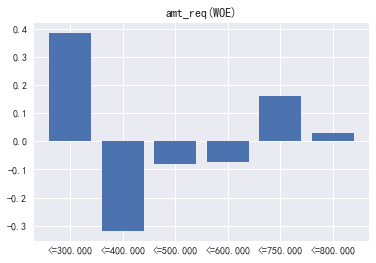

Cutoff:[300, 400, 500, 600, 750, 800]
"rent_own"  :  iv=0.03936528651677712


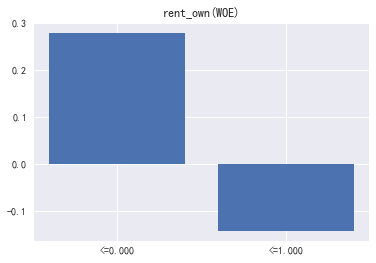

Cutoff:[0, 1]
"mthly_rent_amt"  :  iv=0.020206552867532417


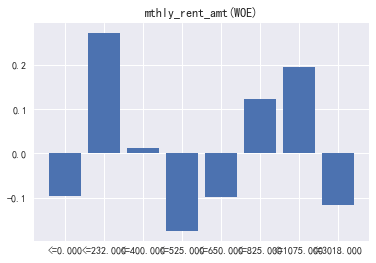

Cutoff:[0, 232, 400, 525, 650, 825, 1075, 3018]
"bank_acct_dd"  :  iv=0.01667293141559368


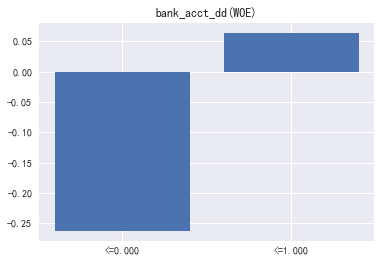

Cutoff:[0, 1]
"loan_dur"  :  iv=0.057781540655364214


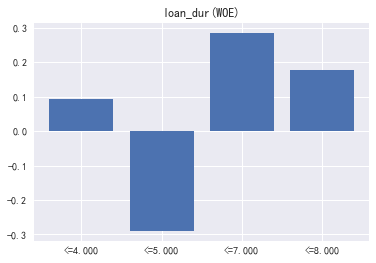

Cutoff:[4, 5, 7, 8]
"pmt_ach"  :  iv=0.0


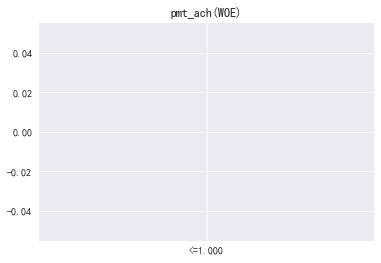

Cutoff:[1]
"nm_pmt"  :  iv=0.32848790065654815


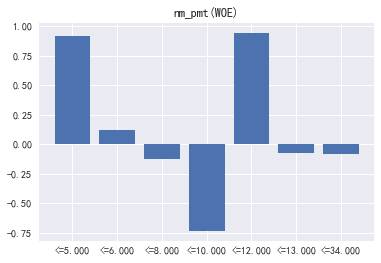

Cutoff:[5, 6, 8, 10, 12, 13, 34]
"pmt_amt"  :  iv=0.33278219334262416


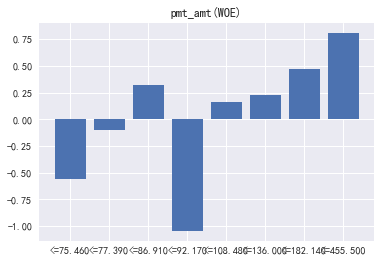

Cutoff:[75.46, 77.39, 86.91, 92.17, 108.48, 136.0, 182.14, 455.5]
"amt_aprv"  :  iv=0.022753467088211504


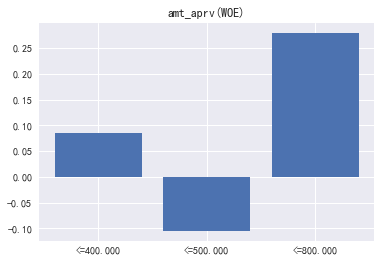

Cutoff:[400, 500, 800]
"dur_aprv"  :  iv=0.06535323055065045


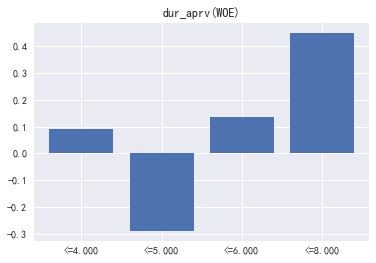

Cutoff:[4, 5, 6, 8]
"pmt_amt_aprv"  :  iv=0.00015429475504987378


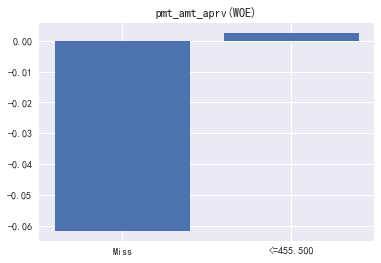

Cutoff:[455.5]
"county"  :  iv=0.17450763804817782


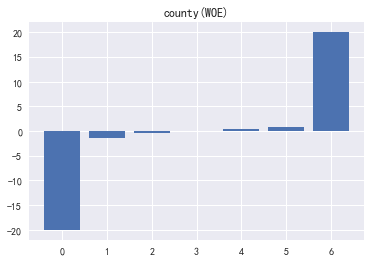

0    [Clay County, Hanson County, Cassia County, Po...
1                    [Canyon County, Minnehaha County]
2    [Salt Lake County, Davis County, Bingham Count...
3    [Tooele County, Ada County, McCook County, San...
4       [Weber County, Utah County, Washington County]
5    [Kootenai County, Latah County, Brown County, ...
6    [Hamlin County, Beadle County, Carbon County, ...
Name: Range, dtype: object
"res_dur"  :  iv=0.045873563615919356


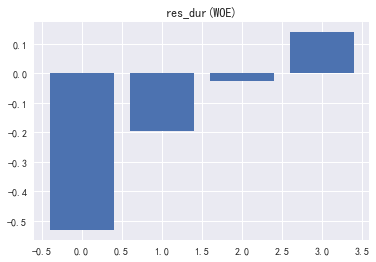

0         [7-12 months]
1    [6 months or less]
2           [1-2 years]
3            [3+ years]
Name: Range, dtype: object
"bank_acct_dur"  :  iv=0.09195835197458005


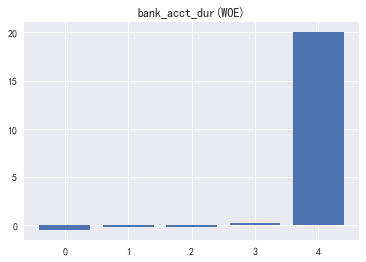

0    [6 months or less]
1           [1-2 years]
2         [7-12 months]
3            [3+ years]
4                 [nan]
Name: Range, dtype: object
"pmt_freq"  :  iv=0.34463606693056686


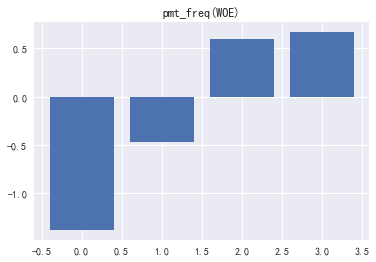

0          [Weekly]
1       [Bi-weekly]
2    [Semi-monthly]
3         [Monthly]
Name: Range, dtype: object
"home_phone_type"  :  iv=0.0021174841306318406


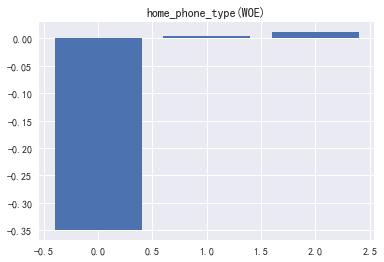

0      [Work]
1    [Mobile]
2      [Home]
Name: Range, dtype: object
"has_other_phone"  :  iv=0.02453121336253721


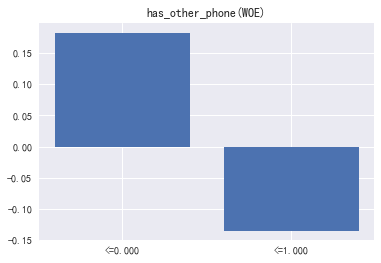

Cutoff:[0, 1]
"how_use_money"  :  iv=0.1327080564032424


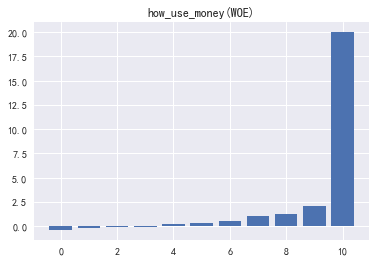

0              [Bills (Auto), Bills (Home / Utilities)]
1                                                 [Car]
2                                               [Bills]
3                              [Other, Bills (Medical)]
4                                                 [nan]
5                                     [Bills (General)]
6                                              [School]
7                            [Rent / Mortgage, Medical]
8                                                [Rent]
9     [Gifts / Leisure, Pay off loans / overdrawn acct]
10                                          [Won't say]
Name: Range, dtype: object
"mthly_income_amt"  :  iv=0.1052237325140501


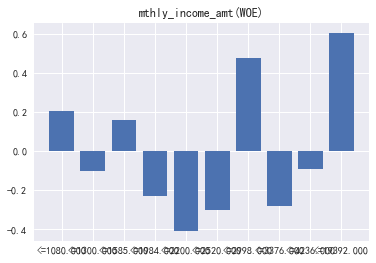

Cutoff:[1080, 1300, 1585, 1984, 2200, 2520, 2998, 3376, 4236, 19392]
"raw_l2c_score"  :  iv=0.12503951970921573


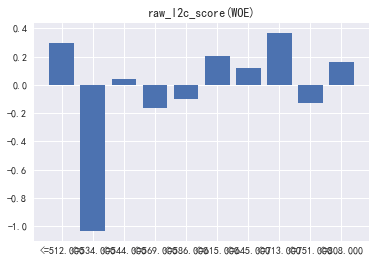

Cutoff:[512, 534, 544, 569, 586, 615, 645, 713, 751, 808]
"raw_FICO_telecom"  :  iv=0.1788278739969028


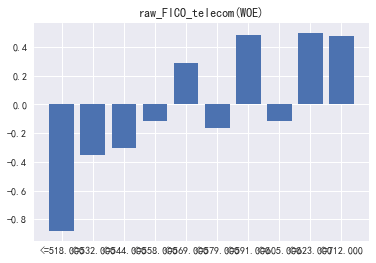

Cutoff:[518, 532, 544, 558, 569, 579, 591, 605, 623, 712]
"raw_FICO_retail"  :  iv=0.26953560252533826


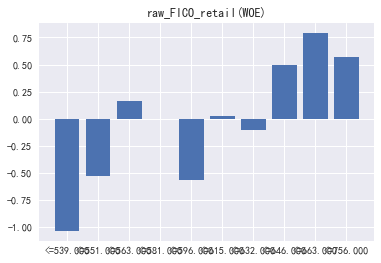

Cutoff:[539, 551, 563, 581, 596, 615, 632, 646, 663, 756]
"raw_FICO_bank_card"  :  iv=0.29527677804668906


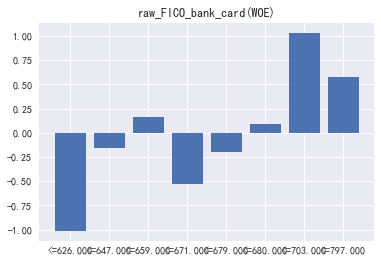

Cutoff:[626, 647, 659, 671, 679, 680, 703, 797]
"raw_FICO_money"  :  iv=0.2248845414965418


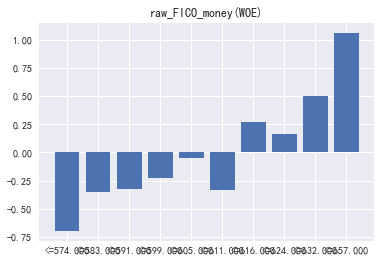

Cutoff:[574, 583, 591, 599, 605, 611, 616, 624, 632, 657]
"req_inc_ratio"  :  iv=0.06497932572350262


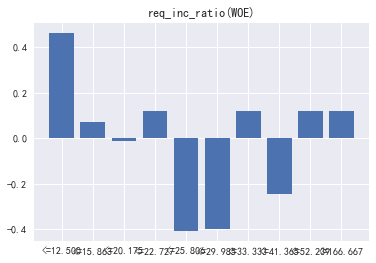

Cutoff:[12.5, 15.86294416, 20.17484869, 22.72727273, 25.80645161, 29.9850075, 33.33333333, 41.36504654, 52.23880597, 166.66666669999995]
"rent_ratio"  :  iv=0.01912688776840628


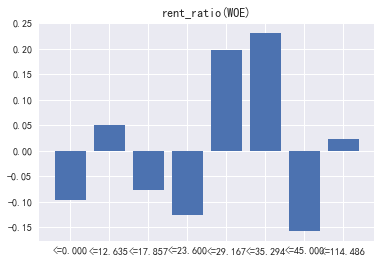

Cutoff:[0.0, 12.63513514, 17.85714286, 23.6, 29.16666667, 35.29411765, 45.0, 114.4859813]
"pmt_ratio"  :  iv=0.1345098984993312


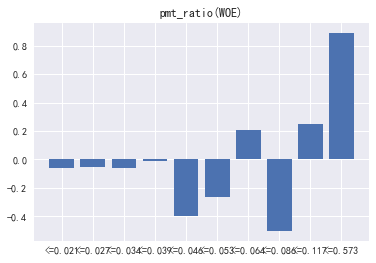

Cutoff:[0.020947727, 0.027108824, 0.033516364, 0.038805871, 0.046083333, 0.053183544000000006, 0.064491667, 0.085988889, 0.116532452, 0.5725]
"pmt_amt_apv_match"  :  iv=0.04742156017249568


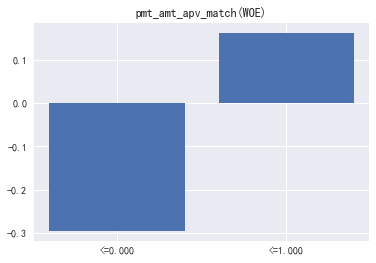

Cutoff:[0, 1]
"amt_apv_match"  :  iv=0.007074403455076419


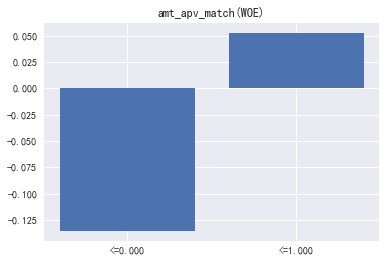

Cutoff:[0, 1]
"name"  :  iv=0.013511870280007802


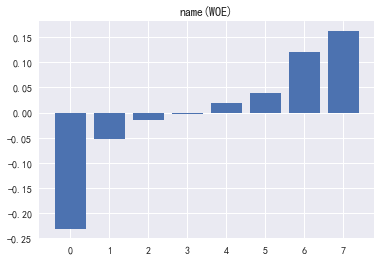

0       [jack ma]
1           [xxd]
2            [yq]
3            [qq]
4        [yuqing]
5           [nan]
6            [dd]
7    [xuxiaodong]
Name: Range, dtype: object


In [15]:
binut.plot_all_woe()

## 手调分箱案例

done.


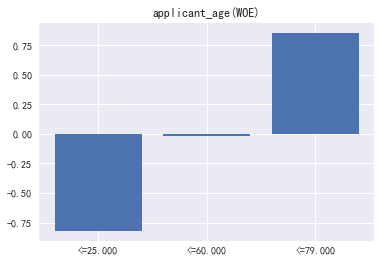

Cutoff:[25, 60, 79]


,Var,Range,Min,Max,CntRec,CntGood,CntBad,Pct,PctBad,PctGood,BadRate,CumGood,CumBad,Odds,LnOdds,WoE,IV,TotalIV
0,applicant_age,<=25.000,19,25,33,24,9,0.071895,0.042654,0.096774,0.272727,24,9,0.375000,-0.980829,-0.819259,0.044338,0.105186
1,applicant_age,<=60.000,26,60,387,211,176,0.843137,0.834123,0.850806,0.454780,235,185,0.834123,-0.181374,-0.019804,0.000330,0.105186
2,applicant_age,<=79.000,61,79,39,13,26,0.084967,0.123223,0.052419,0.666667,248,211,2.000000,0.693147,0.854718,0.060517,0.105186


In [16]:
col = 'applicant_age'
binut.manual_bin(col=col,bins_or_cutoff=[np.nan,25,60])
nb = binut.get_bin(col)
nb.plot_woe()
nb.get_bin_stats()

## 手调分箱之后调用分箱统计函数及iv_ks_auc计算函数

In [19]:
binut.iv_ks_auc().head()

,var,iv,ks,auc
0,applicant_age,0.105186,0.070803,0.557617
1,amt_req,0.026615,0.057617,0.540514
2,rent_own,0.039365,0.093564,0.546782
3,mthly_rent_amt,0.020207,0.062146,0.538765
4,bank_acct_dd,0.016673,0.051158,0.525579


In [17]:
binut.get_all_bin_stats().head()

d:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,BadRate,CntBad,CntGood,CntRec,CumBad,CumGood,IV,LnOdds,Max,Min,Odds,Pct,PctBad,PctGood,Range,TotalIV,Var,WoE
0,0.272727,9,24,33,9,24,0.044338,-0.980829,25.0,19.0,0.375000,0.071895,0.042654,0.096774,<=25.000,0.105186,applicant_age,-0.819259
1,0.454780,176,211,387,185,235,0.000330,-0.181374,60.0,26.0,0.834123,0.843137,0.834123,0.850806,<=60.000,0.105186,applicant_age,-0.019804
2,0.666667,26,13,39,211,248,0.060517,0.693147,79.0,61.0,2.000000,0.084967,0.123223,0.052419,<=79.000,0.105186,applicant_age,0.854718
0,0.555556,25,20,45,25,20,0.014557,0.223144,300.0,250.0,1.250000,0.098039,0.118483,0.080645,<=300.000,0.026615,amt_req,0.384714
1,0.382353,13,21,34,38,41,0.007335,-0.479573,400.0,350.0,0.619048,0.074074,0.061611,0.084677,<=400.000,0.026615,amt_req,-0.318002


## 训练集测试集样本集调用woe转换

In [18]:
train_df = binut.trans_to_woe(train_df)
test_df = binut.trans_to_woe(test_df)
all_woe=binut.trans_to_woe(demo_df)